In [1]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd


In [4]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # Ensure agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0 and self.wealth > 0:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.runnnig = True

        # Create a datacollector to collect data
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y coordinates for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [5]:
params = {"width": 10, "height": 10, "n": range(5, 100, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/95 [00:00<?, ?it/s]

In [9]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


[Text(0.5, 0, 'number of agents'),
 Text(0, 0.5, 'Gini coefficient'),
 Text(0.5, 1.0, 'Gini coefficient vs. number of agents')]

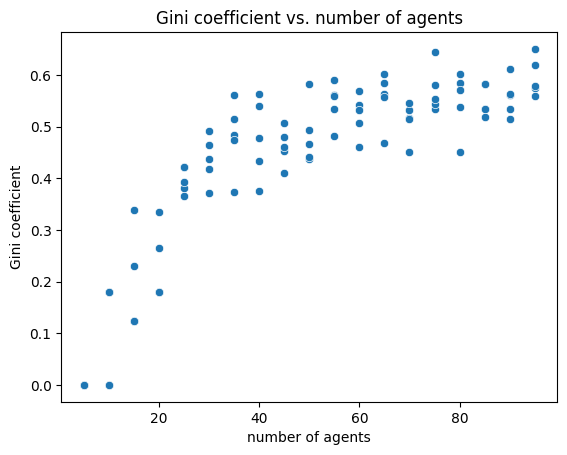

In [21]:
results_filtered = results_df[(results_df.AgentID == 1) & (results_df.Step == 100)]
results_filtered[["iteration", "n", "Gini"]].reset_index(drop=True).head()

g = sns.scatterplot(data=results_filtered, x="n", y="Gini")
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
)

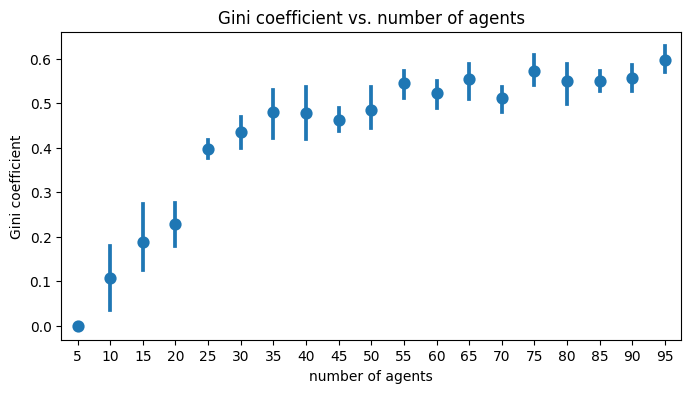

In [22]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x="n", y="Gini", linestyle="None")
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
)

In [23]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.n == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=10
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter notebook
# from IPython.display import display, HTML
# display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0      NaN     NaN
    1      1.0     1.0
    1      2.0     1.0
    1      3.0     1.0
    1      4.0     1.0
  ...      ...     ...
  100      6.0     1.0
  100      7.0     1.0
  100      8.0     1.0
  100      9.0     1.0
  100     10.0     1.0


In [24]:
results_one_episode = results_df[
    (results_df.n == 10) & (results_df.iteration == 1) & (results_df.AgentID == 1)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=10))

 Step  Gini
    1  0.00
    2  0.00
    3  0.00
    4  0.00
    5  0.00
  ...   ...
   96  0.18
   97  0.18
   98  0.18
   99  0.18
  100  0.18


In [ ]:
params = {"seed": None, "width": 10, "height": 10, "n": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=25,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,  # Important, otherwise the datacollector will only collect data of the last time step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

  0%|          | 0/125 [00:00<?, ?it/s]

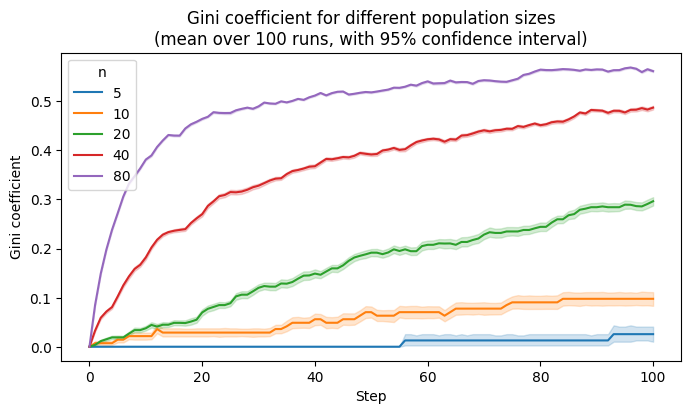

In [27]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="n",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plot_title = "Gini coefficient for different population sizes\n(mean over 100 runs, with 95% confidence interval)"
g.set(title=plot_title, ylabel="Gini coefficient");